## hardware

In [1]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU E5-2698 v4 @ 2.20GHz
stepping	: 1
microcode	: 0xb000040
cpu MHz		: 1200.385
cache size	: 51200 KB
physical id	: 0
siblings	: 40
core id		: 0
cpu cores	: 20
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 20
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush dts acpi mmx fxsr sse sse2 ss ht tm pbe syscall nx pdpe1gb rdtscp lm constant_tsc arch_perfmon pebs bts rep_good nopl xtopology nonstop_tsc cpuid aperfmperf pni pclmulqdq dtes64 monitor ds_cpl vmx smx est tm2 ssse3 sdbg fma cx16 xtpr pdcm pcid dca sse4_1 sse4_2 x2apic movbe popcnt tsc_deadline_timer aes xsave avx f16c rdrand lahf_lm abm 3dnowprefetch cpuid_fault epb cat_l3 cdp_l3 invpcid_single pti intel_ppin ssbd ibrs ibpb stibp tpr_shadow vnmi flexpriority ept vpid ept_ad fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm cqm rdt_a rdseed adx smap 

In [2]:
!nvidia-smi

Tue Sep 24 19:55:05 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.06              Driver Version: 545.23.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Quadro RTX 8000                On  | 00000000:06:00.0 Off |                    0 |
| N/A   35C    P0              55W / 250W |      0MiB / 46080MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## kaggle

In [3]:
# import os

# if not os.path.isdir('/content/train_images/'):
#     #!mkdir -p ~/.kaggle
#     #!cp /content/drive/MyDrive/Kaggle/kaggle.json ~/.kaggle/
#     #!chmod 600 ~/.kaggle/kaggle.json

#     #!kaggle competitions download -c rsna-2024-lumbar-spine-degenerative-classification -p '/content/drive/MyDrive/Kaggle/RSNA 2024 Lumbar Spine Degenerative Classification/DataSources/'

#     !unzip '/content/drive/MyDrive/Kaggle/RSNA 2024 Lumbar Spine Degenerative Classification/DataSources/rsna-2024-lumbar-spine-degenerative-classification.zip'

## library

In [4]:
!pip install albumentations pydicom segmentation_models_pytorch timm transformers monai

In [5]:
import numpy as np
import pandas as pd

import random

import os

import glob

from tqdm import tqdm

from sklearn.model_selection import KFold

import matplotlib.pyplot as plt

import cv2

import json

import shutil

import torch
import torch.nn as nn
import torch.nn.functional as F

import albumentations as A

import pydicom

import timm

from transformers.optimization import AdamW, get_cosine_schedule_with_warmup
from transformers import RobertaPreLayerNormConfig, RobertaPreLayerNormModel

from segmentation_models_pytorch.decoders.unet.model import (
    UnetDecoder,
    SegmentationHead,
)

import monai.transforms as transforms

from scipy.ndimage import gaussian_filter
DATA_DIR = 'data'

## config

In [6]:
class CustomConfig:
    seed = 42
    device = 'cuda'
    root = DATA_DIR

    train = pd.read_csv(f'{DATA_DIR}/train.csv')
    label_columns = train.columns[1:]

    orientation = ['Sagittal T2/STIR', 'Sagittal T1', 'Axial T2'][2]

    if orientation == 'Sagittal T2/STIR':
        label_columns = label_columns[0:5]
    elif orientation == 'Sagittal T1':
        label_columns = label_columns[5:15]
    elif orientation == 'Axial T2':
        label_columns = label_columns[15:25]
    else:
        raise NotImplementedError()

    volume_size = {
        'Sagittal T2/STIR' : [32, 256, 256],
        'Sagittal T1' : [32, 256, 256],
        'Axial T2' : [192, 256, 256]
    }[orientation]

    sigma = {
        'Sagittal T2/STIR' : 4,
        'Sagittal T1' : 4,
        'Axial T2' : 4
    }[orientation]

    n_fold = 5

    batch_size = 2
    n_worker = 8

    lr = 1e-4
    wd = 1e-2
    n_epoch = 40
    warmup_ratio = 0.1
    test_freq = 1
    mix_prob = 0.0

    coordinate_columns = {
        'Sagittal T2/STIR' : [
            ['Spinal Canal Stenosis', 'L1/L2'],
            ['Spinal Canal Stenosis', 'L2/L3'],
            ['Spinal Canal Stenosis', 'L3/L4'],
            ['Spinal Canal Stenosis', 'L4/L5'],
            ['Spinal Canal Stenosis', 'L5/S1'],
        ],
        'Sagittal T1' : [
            ['Left Neural Foraminal Narrowing', 'L1/L2'],
            ['Left Neural Foraminal Narrowing', 'L2/L3'],
            ['Left Neural Foraminal Narrowing', 'L3/L4'],
            ['Left Neural Foraminal Narrowing', 'L4/L5'],
            ['Left Neural Foraminal Narrowing', 'L5/S1'],

            ['Right Neural Foraminal Narrowing', 'L1/L2'],
            ['Right Neural Foraminal Narrowing', 'L2/L3'],
            ['Right Neural Foraminal Narrowing', 'L3/L4'],
            ['Right Neural Foraminal Narrowing', 'L4/L5'],
            ['Right Neural Foraminal Narrowing', 'L5/S1'],
        ],
        'Axial T2' : [
            ['Left Subarticular Stenosis', 'L1/L2'],
            ['Left Subarticular Stenosis', 'L2/L3'],
            ['Left Subarticular Stenosis', 'L3/L4'],
            ['Left Subarticular Stenosis', 'L4/L5'],
            ['Left Subarticular Stenosis', 'L5/S1'],

            ['Right Subarticular Stenosis', 'L1/L2'],
            ['Right Subarticular Stenosis', 'L2/L3'],
            ['Right Subarticular Stenosis', 'L3/L4'],
            ['Right Subarticular Stenosis', 'L4/L5'],
            ['Right Subarticular Stenosis', 'L5/S1'],
        ],
    }

if __name__ == "__main__":
    args = CustomConfig()

## seed

In [7]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

if __name__ == "__main__":
    seed_everything(args.seed)

## utils

In [8]:
def volume2point(volumes):
    volumes = volumes.cpu()

    batch_size, n_class, _, h, w = volumes.shape

    points = []
    for i in range(batch_size):
        volume = volumes[i]

        point = []
        for j in range(n_class):
            flat_volume = volume[j].reshape(-1)
            max_idx = torch.argmax(flat_volume)

            z = max_idx // (h * w)
            y = (max_idx % (h * w)) // w
            x = (max_idx % (h * w)) % w
            point.append(torch.stack([z, y, x]))

        point = torch.stack(point, dim = 0)
        points.append(point)

    points = torch.stack(points, dim = 0)
    return points.numpy()

## preprocess

In [9]:
def preprocess(args):
    train = pd.read_csv(f'{DATA_DIR}/train.csv')

    folds = []

    kf = KFold(n_splits = args.n_fold, shuffle = True, random_state = args.seed)
    for train_indices, test_indices in kf.split(train):

        train_df = train.loc[train_indices].reset_index(drop = True)
        test_df = train.loc[test_indices].reset_index(drop = True)

        folds.append([train_df, test_df])

    return train, folds

if __name__ == "__main__":
    train, folds = preprocess(args)

## dataset

In [10]:
class CustomTransform(nn.Module):
    def __init__(self, args, train = False, volume_size = None):
        super(CustomTransform, self).__init__()

        if train:
            self.transform = A.Compose([
                A.ShiftScaleRotate(border_mode = cv2.BORDER_CONSTANT, p = 0.75),
                A.RandomBrightnessContrast(p = 0.75),
            ])

        else:
            self.transform = A.Compose([
            ])

    def forward(self, x, y):
        c, z, h, w = y.shape

        x = x.permute(1, 2, 0)
        x = x.numpy()

        y = y.reshape(c * z, h, w)
        y = y.permute(1, 2, 0)
        y = y.numpy()

        results = self.transform(image = x, mask = y)
        x, y = results['image'], results['mask']

        x = torch.tensor(x, dtype = torch.float)
        x = x.permute(2, 0, 1)

        y = torch.tensor(y, dtype = torch.float)
        y = y.permute(2, 0, 1)

        _, h, w = y.shape
        y = y.reshape(c, z, h, w)
        return x, y

inputs :  torch.Size([192, 256, 256])
targets :  torch.Size([10, 192, 256, 256])
masks :  torch.Size([10, 192])
[[[ 31 146 114]
  [ 24 134 123]
  [ 18 132 131]
  [ 12 128 131]
  [  7 134 129]
  [ 31 128  90]
  [ 24 118 102]
  [ 18 114 112]
  [ 13 115 119]
  [  7 120 112]]]


ValueError: Image size of 96000x1000 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 96000x1000 with 384 Axes>

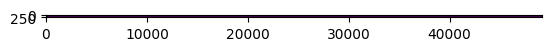

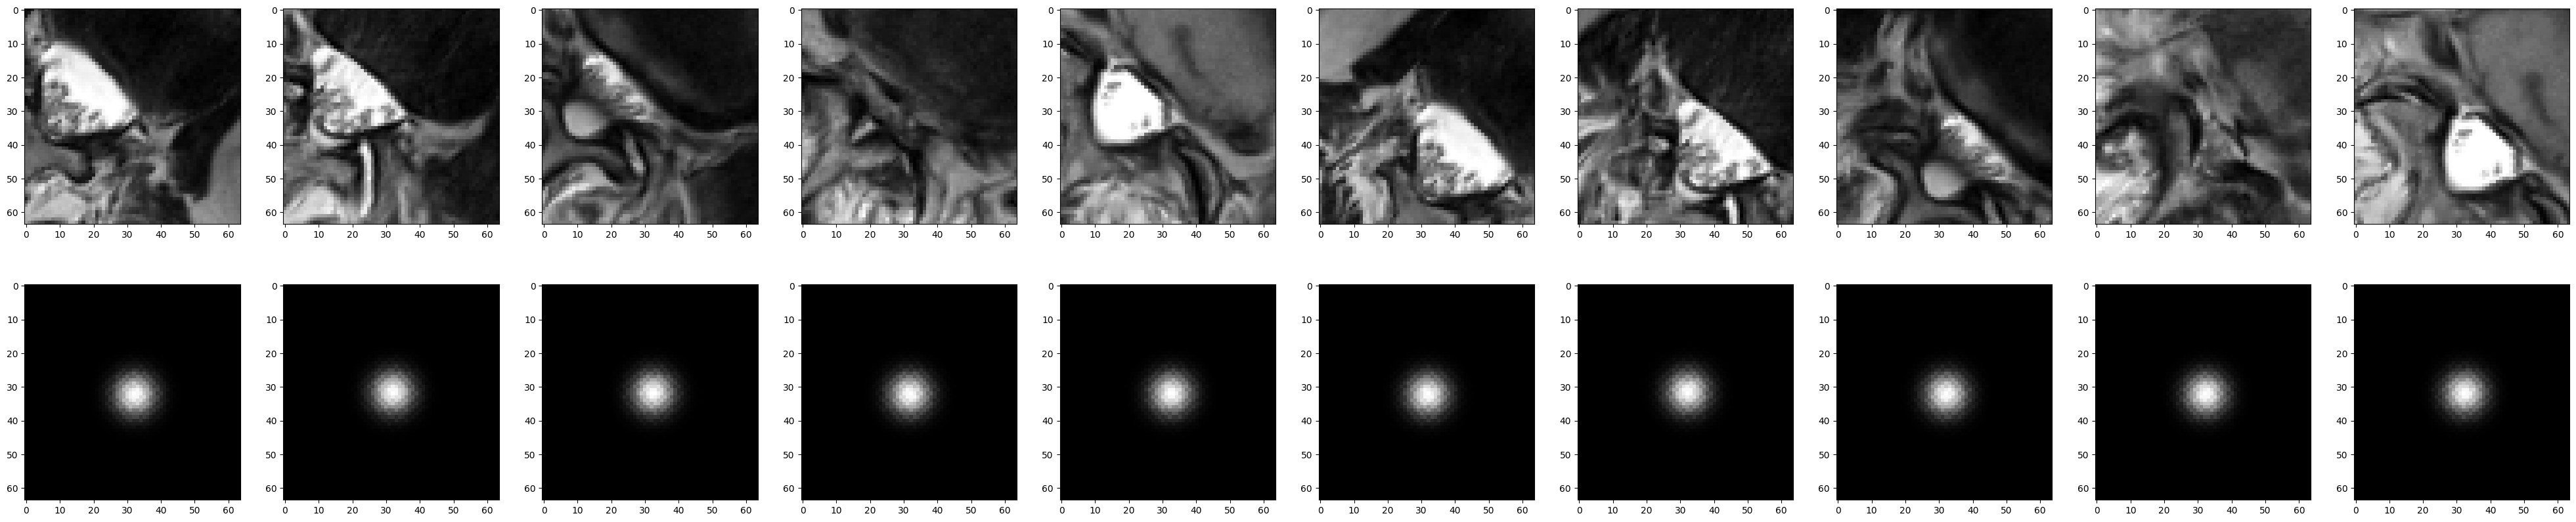

In [11]:
def convert_to_8bit(x):
    lower, upper = np.percentile(x, (1, 99))
    x = np.clip(x, lower, upper)
    x = x - np.min(x)
    x = x / np.max(x)
    return (x * 255).astype("uint8")

def get_imgs(dcms):
    imgs = []
    for dcm in dcms:
        img = convert_to_8bit(dcm.pixel_array)
        imgs.append(img)
    try:
        return np.stack(imgs, axis = 0)
    except:
        h, w = imgs[0].shape
        imgs = [A.Resize(h, w)(image = x)['image'] for x in imgs]
        return np.stack(imgs, axis = 0)

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, args, df, train = False):
        self.args = args
        self.df = df
        self.train = train

        self.orientation = args.orientation
        self.volume_size = args.volume_size

        self.transform = CustomTransform(args, self.train, self.volume_size)

        self.train_series_descriptions = pd.read_csv(f'{DATA_DIR}/train_series_descriptions.csv')
        self.train_label_coordinates = pd.read_csv(f'{DATA_DIR}/train_label_coordinates.csv')

    def __len__(self):
        return len(self.df)

    def get_subvolume(self, study_id, series_id):
        dicoms = sorted(glob.glob(self.args.root + f'/train_images/{study_id}/{series_id}/*.dcm'), key = lambda x: int(x.split('/')[-1].split('.')[0]))     
        dicoms = [pydicom.dcmread(x) for x in dicoms]
        
        if 'Sagittal' in self.orientation:
            pos = np.asarray([dicom.ImagePositionPatient for dicom in dicoms])[:, 0]
        else:
            pos = np.asarray([dicom.ImagePositionPatient for dicom in dicoms])[:, -1]
            orien = np.asarray([dicom.ImageOrientationPatient for dicom in dicoms])


        inputs = get_imgs(dicoms)
        inputs = A.Resize(self.volume_size[1], self.volume_size[2])(image = inputs.transpose(1, 2, 0))['image'].transpose(2, 0, 1)
        inputs = torch.tensor(inputs, dtype = torch.float)
        inputs = inputs / 255.0

        return inputs, pos

    def get_inputs(self, row):
        row_series_descriptions = self.train_series_descriptions[self.train_series_descriptions['study_id'] == row['study_id']]
        row_series_descriptions = row_series_descriptions[row_series_descriptions['series_description'] == self.orientation].reset_index(drop = True)
        
        
        if len(row_series_descriptions) > 0:
            inputs, pos = [], []
            for i in range(len(row_series_descriptions)):
                study_id, series_id, _ = row_series_descriptions.loc[i]
                
                _inputs, _pos = self.get_subvolume(study_id, series_id)
                inputs.append(_inputs)
                pos.append(_pos)

            inputs = torch.cat(inputs, dim = 0)
            pos = np.concatenate(pos, axis = 0)
        else:
            inputs = torch.zeros(self.volume_size, dtype = torch.float32)
            pos = np.zeros([self.volume_size[0]], dtype = np.float32)

        return inputs, pos

    def get_targets(self, row, inputs):
        row_series_descriptions = self.train_series_descriptions[self.train_series_descriptions['study_id'] == row['study_id']]
        row_series_descriptions = row_series_descriptions[row_series_descriptions['series_description'] == self.orientation].reset_index(drop = True)
        targets = np.zeros([len(self.args.coordinate_columns[self.orientation])] + [inputs.shape[0]] + self.volume_size[1:], dtype = np.float32)

        if len(row_series_descriptions) > 0:
            dicoms = []
            series_ids = []
            for i in range(len(row_series_descriptions)):
                study_id, series_id, _ = row_series_descriptions.loc[i]

                d = sorted(glob.glob(f'{DATA_DIR}/train_images/{study_id}/{series_id}/*.dcm'), key = lambda x: int(x.split('/')[-1].split('.')[0]))
                series_ids += [series_id]*len(d)
                dicoms += d
            instance_numbers = [int(x.split('/')[-1].split('.')[0]) for x in dicoms]
            instance_serie2index = {(instance_numbers[i], series_ids[i]):i for i in range(len(instance_numbers))}

            for series_id in set(series_ids):
                label_coordinate = self.train_label_coordinates[(self.train_label_coordinates['study_id'] == study_id) & (self.train_label_coordinates['series_id'] == series_id)].reset_index(drop = True)
                for i in range(len(self.args.coordinate_columns[self.orientation])):

                    condition, level = self.args.coordinate_columns[self.orientation][i][0], self.args.coordinate_columns[self.orientation][i][1]
                    try:
                        _, _, instance_number, _, _, x, y = label_coordinate[(label_coordinate['condition'] == condition) & (label_coordinate['level'] == level)].reset_index(drop = True).loc[0]
                    except:
                        continue;
                    h, w = pydicom.dcmread(f'{DATA_DIR}/train_images/{study_id}/{series_id}/{instance_number}.dcm').pixel_array.shape
                    z = instance_serie2index[(instance_number, series_id)]

                    z_i = z
                    y_i = round(y * (self.volume_size[1] / h))
                    x_i = round(x * (self.volume_size[2] / w))

                    targets[i, z_i, y_i, x_i] = 1

                    targets[i, z_i] = gaussian_filter(targets[i, z_i], sigma = (self.args.sigma, self.args.sigma))
                    targets[i, z_i] = targets[i, z_i] / targets[i, z_i].max()

                    targets[i, max(0, z_i - 2)] = targets[i, z_i] / 2**2
                    targets[i, max(0, z_i - 1)] = targets[i, z_i] / 2**1

                    targets[i, min(targets.shape[1] - 1, z_i + 2)] = targets[i, z_i] / 2**2
                    targets[i, min(targets.shape[1] - 1, z_i + 1)] = targets[i, z_i] / 2**1

        targets = torch.tensor(targets, dtype = torch.float)
        return targets



    def get_masks(self, inputs, targets):
        temporal_masks = (inputs.sum(dim = [1, 2]) != 0).float()
        spatial_masks = (targets.sum(dim = [1, 2, 3]) != 0).float()

        masks = temporal_masks[None, :] * spatial_masks[:, None]
        return masks

    def __getitem__(self, index):
        row = self.df.loc[index]
        inputs, pos = self.get_inputs(row)
        targets = self.get_targets(row, inputs)
        
        pos = np.argsort(pos)

        inputs = inputs[pos]
        targets = targets[:, pos]

        if inputs.shape[0] > self.volume_size[0]:
            inputs = F.interpolate(inputs.unsqueeze(0).unsqueeze(0), size = self.volume_size, mode = 'trilinear').squeeze(0).squeeze(0)
            targets = F.interpolate(targets.unsqueeze(0), size = self.volume_size, mode = 'trilinear').squeeze(0)

        inputs, targets = self.transform(inputs, targets)

        inputs = torch.cat([inputs, torch.zeros([self.volume_size[0] - inputs.shape[0]] + list(inputs.shape[1:]), dtype = torch.float)], dim = 0)
        targets = torch.cat([targets, torch.zeros([len(self.args.coordinate_columns[self.orientation])] + [self.volume_size[0] - targets.shape[1]] + list(inputs.shape[1:]), dtype = torch.float)], dim = 1)

        
        masks = self.get_masks(inputs, targets)
        return inputs, targets, masks

if __name__ == "__main__":
    train_df, test_df = folds[0]
    dataset = CustomDataset(args, train_df, train = True)

    index = random.randint(0, len(dataset) - 1)
    inputs, targets, masks = dataset[index]

    print('inputs : ', inputs.shape)
    print('targets : ', targets.shape)
    print('masks : ', masks.shape)

    print(volume2point(targets[None]))

    fig, axes = plt.subplots(2, targets[0].shape[0], figsize = (5 * targets[0].shape[0], 5 * 2))
    for i in range(targets[0].shape[0]):
        axes[0, i].imshow(inputs[i], cmap = 'gray')
        axes[1, i].imshow(targets[0][i], cmap = 'gray')
    plt.show()
    plt.imshow(targets[0].permute(1, 0, 2).reshape(256, -1))
    plt.show()

    patch_size = {'Sagittal T2/STIR' : 32, 'Sagittal T1' : 32, 'Axial T2' : 32}[args.orientation]
    fig, axes = plt.subplots(2, targets.shape[0], figsize = (5 * targets.shape[0], 5 * 2))

    points = volume2point(targets[None])[0]
    for i in range(targets.shape[0]):
        z, y, x = points[i]
        if points[i].sum() != 0:
            axes[0, i].imshow(inputs[z, y-patch_size:y+patch_size, x-patch_size:x+patch_size], cmap = 'gray')
            axes[1, i].imshow(targets[i][z, y-patch_size:y+patch_size, x-patch_size:x+patch_size], cmap = 'gray')
    plt.show()

## model

In [12]:
class Segmenter(nn.Module):
    def __init__(self,
                 args,
                 n_channel,
                 ):
        super(Segmenter, self).__init__()
        self.args = args

        self.n_class = len(args.label_columns)
        self.n_channel = n_channel

        self.extracter = timm.create_model(
            model_name = 'regnety_002',
            pretrained = True,
            features_only = True,
            in_chans = n_channel,
        )

        encoder_channels = [n_channel] + [self.extracter.feature_info[i]["num_chs"] for i in range(len(self.extracter.feature_info))]
        decoder_channels = [256, 128, 64, 32, 16]

        self.decoder = UnetDecoder(
            encoder_channels = encoder_channels,
            decoder_channels = decoder_channels,
            n_blocks = 5,
            use_batchnorm = True,
            center = False,
            attention_type = None,
        )

        self.head = SegmentationHead(
            in_channels = decoder_channels[-1],
            out_channels = self.n_class,
            activation = None,
            kernel_size= 3,
        )

    def forward(self, x):
        x = x.reshape(-1, self.n_channel, self.args.volume_size[1], self.args.volume_size[2])
        _x = self.extracter(x)

        x = self.decoder(*[x] + _x)
        x = self.head(x)

        x = x.reshape(-1, self.args.volume_size[0], self.n_class, self.args.volume_size[1], self.args.volume_size[2])
        x = x.permute(0, 2, 1, 3, 4)
        return x

In [13]:
class Pointer(nn.Module):
    def __init__(self,
                 args,
                 n_channel,
                 hidden_size,
                 drop_rate,
                 ):
        super(Pointer, self).__init__()
        self.args = args

        self.n_channel = n_channel

        self.extracter = timm.create_model(
            model_name = 'regnety_002',
            pretrained = True,
            features_only = True,
            in_chans = n_channel,
        )

        self.dense_size = self.extracter.feature_info[-1]["num_chs"]

        self.dense = nn.Linear(self.dense_size, hidden_size)

        self.transformer = RobertaPreLayerNormModel(
            RobertaPreLayerNormConfig(
                hidden_size = hidden_size,
                num_hidden_layers = 1,
                num_attention_heads = 4,
                intermediate_size = 4 * hidden_size,
                hidden_act = 'gelu',
                )
            )
        del self.transformer.embeddings.word_embeddings

        self.out = nn.Sequential(
            nn.Dropout(p = drop_rate),
            nn.Linear(hidden_size, len(args.label_columns))
        )

    def forward(self, x, mask):
        x = x.reshape(-1, self.n_channel, self.args.volume_size[1], self.args.volume_size[2])
        x = self.extracter(x)
        x = x[-1].mean(dim = [2, 3])

        x = x.reshape(-1, self.args.volume_size[0], self.dense_size)
        x = self.dense(x)
        x = self.transformer(inputs_embeds = x, attention_mask = mask).last_hidden_state
        x = self.out(x)

        x = x.permute(0, 2, 1)
        return x

In [14]:
class CustomModel(nn.Module):
    def __init__(self,
                 args,
                 n_channel = 3,
                 hidden_size = 256,
                 drop_rate = 0.3,
                 ):

        super(CustomModel, self).__init__()
        self.args = args

        self.n_channel = n_channel
        self.n_class = len(args.label_columns)

        self.segmenter = Segmenter(
            args = args,
            n_channel = n_channel,
            )

        self.pointer = Pointer(
            args = args,
            n_channel = n_channel,
            hidden_size = hidden_size,
            drop_rate = drop_rate,
        )

    def get_inputs(self, x):
        x = F.pad(x, (0, 0, 0, 0, (self.n_channel-1)//2, (self.n_channel-1)//2), "constant", 0)
        x = [x[:, i:i+self.n_channel] for i in range(self.args.volume_size[0])]
        x = torch.stack(x, dim = 1)
        return x

    def get_masks(self, x):
        x = (x.sum(dim = [2, 3]) != 0).float()
        return x

    def get_outputs(self, x1, x2, mask):
        x1 = torch.sigmoid(x1)
        x2 = torch.sigmoid(x2)

        x = x1 * x2[:, :, :, None, None] * mask[:, None, :, None, None]
        return x

    def forward(self, x):
        
        x = x.reshape(-1, self.args.volume_size[0], self.args.volume_size[1], self.args.volume_size[2])
        mask = self.get_masks(x)

        x = self.get_inputs(x)

        x1 = self.segmenter(x)

        x2 = self.pointer(x, mask)
                
        
        return x1, x2, self.get_outputs(x1, x2, mask)

if __name__ == "__main__":
    loader = torch.utils.data.DataLoader(dataset, batch_size = args.batch_size, num_workers = args.n_worker)
    sample = next(iter(loader))
    sample = [x.to(args.device) for x in sample]

    model = CustomModel(args)
    model = model.to(args.device)

    with torch.no_grad():
        outputs1, outputs2, outputs = model(sample[0])
        print(outputs1.shape)
        print(outputs2.shape)
        print(outputs.shape)

torch.Size([2, 10, 192, 256, 256])
torch.Size([2, 10, 192])
torch.Size([2, 10, 192, 256, 256])


## loss

In [15]:
class CustomLoss(nn.Module):
    def __init__(self, args):
        super(CustomLoss, self).__init__()
        self.args = args

        self.bce_loss = nn.BCEWithLogitsLoss(reduction = 'none')

    def get_trues(self, trues):
        if self.args.orientation == 'Sagittal T2/STIR':
            pass

        elif self.args.orientation == 'Sagittal T1':
            '''
            [1, 0, 0, 0, 0, 1, 0, 0, 0, 0]
            [0, 1, 0, 0, 0, 0, 1, 0, 0, 0]
            [0, 0, 1, 0, 0, 0, 0, 1, 0, 0]
            [0, 0, 0, 1, 0, 0, 0, 0, 1, 0]
            [0, 0, 0, 0, 1, 0, 0, 0, 0, 1]
            [1, 0, 0, 0, 0, 1, 0, 0, 0, 0]
            [0, 1, 0, 0, 0, 0, 1, 0, 0, 0]
            [0, 0, 1, 0, 0, 0, 0, 1, 0, 0]
            [0, 0, 0, 1, 0, 0, 0, 0, 1, 0]
            [0, 0, 0, 0, 1, 0, 0, 0, 0, 1]
            '''
            trues[:, 0], trues[:, 5] = [trues[:, 0] + trues[:, 5]] * 2
            trues[:, 1], trues[:, 6] = [trues[:, 1] + trues[:, 6]] * 2
            trues[:, 2], trues[:, 7] = [trues[:, 2] + trues[:, 7]] * 2
            trues[:, 3], trues[:, 8] = [trues[:, 3] + trues[:, 8]] * 2
            trues[:, 4], trues[:, 9] = [trues[:, 4] + trues[:, 9]] * 2
            return trues

        elif self.args.orientation == 'Axial T2':
            '''
            [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
            [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
            [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
            [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
            [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
            [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
            [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
            [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
            [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
            [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
            '''
            trues[:, 0], trues[:, 1], trues[:, 2], trues[:, 3], trues[:, 4] = [trues[:, 0] + trues[:, 1] + trues[:, 2] + trues[:, 3] + trues[:, 4]] * 5
            trues[:, 5], trues[:, 6], trues[:, 7], trues[:, 8], trues[:, 9] = [trues[:, 5] + trues[:, 6] + trues[:, 7] + trues[:, 8] + trues[:, 9]] * 5
            return trues

        else:
            raise NotImplementedError()

        return trues


    def get_loss1(self, preds, trues, masks):
        trues = self.get_trues(trues.clone())
        loss = self.bce_loss(preds, trues)
        xy_mask = (trues.sum(dim = [3, 4]) != 0).float()
        loss = loss.mean(dim = [3, 4])
#         loss = (loss * masks).sum() / masks.sum()
        loss = (loss * xy_mask).sum() / xy_mask.sum()
        return loss

    def get_loss2(self, preds, trues, masks):
        trues = trues.amax(dim = [3, 4])
        loss = self.bce_loss(preds, trues)
        loss = (loss * masks).sum() / masks.sum()
        return loss

    def forward(self, preds1, preds2, trues, masks):
        loss1 = self.get_loss1(preds1, trues, masks)
        loss2 = self.get_loss2(preds2, trues, masks)

        loss = (loss1 + loss2)
        return loss

if __name__ == "__main__":
    loader = torch.utils.data.DataLoader(dataset, batch_size = args.batch_size, num_workers = args.n_worker)
    sample = next(iter(loader))
    sample = [x.to(args.device) for x in sample]

    model = CustomModel(args)
    model = model.to(args.device)

    loss_fn = CustomLoss(args)

    with torch.no_grad():
        outputs1, outputs2, _ = model(sample[0])
        loss = loss_fn(outputs1, outputs2, sample[1], sample[2])
        print(loss)

tensor(1.6654, device='cuda:0')


## train

In [16]:
class CustomTrainer:
    def __init__(self, args, model):
        self.model = model

        self.scaler = torch.cuda.amp.GradScaler()

        if not os.path.exists(args.save_dir):
            os.makedirs(args.save_dir)

        self.log_path = f'{args.save_dir}/log.txt'

        self.optimizer = torch.optim.AdamW(model.parameters(), lr = args.lr, weight_decay = args.wd)

        total_steps = args.total_steps
        warmup_steps = int(total_steps * args.warmup_ratio)
        print('total_steps: ', total_steps)
        print('warmup_steps: ', warmup_steps)

        self.scheduler = get_cosine_schedule_with_warmup(self.optimizer,
                                                         num_warmup_steps = warmup_steps,
                                                         num_training_steps = total_steps)


        self.train_loss_fn = CustomLoss(args)
        self.test_loss_fn = CustomLoss(args)

    def run(self, args, train_loader, test_loader):
        for epoch in range(args.n_epoch):
            lr = self.optimizer.param_groups[0]['lr']
            train_loss = self.train_function(args, train_loader)

            train_log = f'epoch : {epoch + 1}, lr : {lr}, train_loss: {train_loss:.6f}'
            self.log(args, train_log)

            if ((epoch + 1) % args.test_freq) == 0:
                test_loss, score_dicts = self.test_function(args, test_loader)

                test_score = score_dicts['zyx mean difference']

                test_log = f'epoch : {epoch + 1}, lr : {lr}, test_loss: {test_loss:.6f}, test_score: {test_score:.6f}\n'
                self.log(args, test_log)

                score_log = json.dumps(score_dicts, indent = 4)
                self.log(args, score_log)

                save_path = args.save_dir + '/epoch' + f'{epoch + 1}'.zfill(3) + \
                            f'-trainloss{round(train_loss, 6)}' + \
                            f'-testloss{round(test_loss, 6)}' + \
                            f'-testscore{round(test_score, 6)}' + '.bin'
                torch.save(model.state_dict(), save_path)

    def train_function(self, args, loader):
        self.model.train()

        total_loss = 0.0
        for bi, sample in enumerate(tqdm(loader)):
            sample = [x.to(args.device) for x in sample]

            inputs = sample[0]
            targets = sample[1]
            masks = sample[2]

            self.optimizer.zero_grad()

            with torch.amp.autocast(args.device):
                outputs1, outputs2, _ = self.model(inputs)

            loss = self.train_loss_fn(outputs1, outputs2, targets, masks)

            self.scaler.scale(loss).backward()
            self.scaler.step(self.optimizer)
            self.scaler.update()

            self.scheduler.step()

            total_loss += loss.detach().cpu().tolist()

        return total_loss/len(loader)

    def test_function(self, args, loader):
        self.model.eval()

        total_loss = 0.0

        preds = np.zeros([len(loader.dataset.df), len(args.label_columns), 3], dtype = int)
        trues = np.zeros([len(loader.dataset.df), len(args.label_columns), 3], dtype = int)
        masks = np.zeros([len(loader.dataset.df), len(args.label_columns)], dtype = int)
        for bi, sample in enumerate(tqdm(loader)):
            sample = [x.to(args.device) for x in sample]

            inputs = sample[0]
            targets = sample[1]
            _masks = sample[2]

            with torch.no_grad():
                outputs1, outputs2, outputs = self.model(inputs)
                loss = self.test_loss_fn(outputs1, outputs2, targets, _masks)

            total_loss += loss.detach().cpu().tolist()

            preds[(bi)*args.batch_size:(bi + 1)*args.batch_size, :, :] = volume2point(outputs)
            trues[(bi)*args.batch_size:(bi + 1)*args.batch_size, :, :] = volume2point(targets)
            masks[(bi)*args.batch_size:(bi + 1)*args.batch_size, :] = (_masks.sum(2) != 0).long().cpu().numpy()

        pred = volume2point(outputs[0][None])[0]
        true = volume2point(targets[0][None])[0]
        print('pred : ', pred)
        print('true : ', true)

        outputs = outputs[0].cpu()
        targets = targets[0].cpu()

        fig, axes = plt.subplots(true.shape[0], 2, figsize = (5 * 2, 5 * true.shape[0]))
        for i in range(true.shape[0]):
            z, y, x = true[i]
            axes[i, 0].imshow(outputs[i][z], cmap = 'gray')
            axes[i, 1].imshow(targets[i][z], cmap = 'gray')
        plt.show()

        plt.imshow(targets[0].permute(1, 0, 2).reshape(256, -1));plt.show()
        plt.imshow(outputs[0].permute(1, 0, 2).reshape(256, -1));plt.show()

        errors = np.abs(preds - trues)

        z_diff = (errors[:, :, 0] * masks).sum() / masks.sum()
        y_diff = (errors[:, :, 1] * masks).sum() / masks.sum()
        x_diff = (errors[:, :, 2] * masks).sum() / masks.sum()

        distance = (np.sqrt((errors ** 2).sum(2)) * masks).sum() / masks.sum()

        score_dicts = {
            'zyx mean difference' : (z_diff + y_diff + x_diff) / 3,
            'z-axis difference' : z_diff,
            'y-axis difference' : y_diff,
            'x-axis difference' : x_diff,
            'distance' : distance
        }
        return total_loss/len(loader), score_dicts

    def log(self, args, message):
        print(message)
        with open(f'{args.save_dir}/log.txt', 'a+') as logger:
            logger.write(f'{message}\n')

## run

In [ ]:
if __name__ == "__main__":
    args = CustomConfig()

    args.test_freq = 5

    train, folds = preprocess(args)

    for i in range(args.n_fold):
        seed_everything(args.seed)

        train_df, test_df = folds[i]

        #train_df = train_df[:100]
        #test_df = test_df[:25]

        train_dataset = CustomDataset(args, train_df, train = True)
        test_dataset = CustomDataset(args, test_df, train = False)

        train_loader = torch.utils.data.DataLoader(train_dataset,
                                                   batch_size = args.batch_size,
                                                   num_workers = args.n_worker,
                                                   shuffle = True,
                                                   drop_last = True)
        test_loader = torch.utils.data.DataLoader(test_dataset,
                                                  batch_size = args.batch_size,
                                                  num_workers = args.n_worker,
                                                  shuffle = True,
                                                  drop_last = False)

        model = CustomModel(args)
        model = model.to(args.device)        

        save_name = {
            'Sagittal T2/STIR' : f'sagittal_t2',
            'Sagittal T1' : f'sagittal_t1',
            'Axial T2' : f'axial_t2',
        }[args.orientation]

        name = f'stage1/2.5d-volumesize(*, 256, 256)-pointer(transformer)/{save_name}'
        args.save_dir = args.root + name + f'/fold{i+1}'
        args.total_steps = int(len(train_df) * args.n_epoch/(args.batch_size))

        trainer = CustomTrainer(args, model)
        trainer.run(args, train_loader, test_loader)

        break

total_steps:  31600
warmup_steps:  3160


100%|██████████| 790/790 [20:50<00:00,  1.58s/it]


epoch : 1, lr : 0.0, train_loss: 0.831926


100%|██████████| 790/790 [20:54<00:00,  1.59s/it]


epoch : 2, lr : 2.5e-05, train_loss: 0.320426


  2%|▏         | 16/790 [00:36<20:22,  1.58s/it] 